In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.reset_option('display.float_format', silent=True)
nft_trades = pd.read_csv('nft_traders_flipside.csv')
nft_trades['avg_nb_hours_between_hold_trade'] = nft_trades['avg_nb_minutes_between_hold_trade'] /60
nft_trades.drop(['X__row_index','avg_nb_minutes_between_hold_trade'],axis=1,inplace=True)
nft_trades.dropna(inplace=True)

In [3]:
features = ['total_sol_amount_traded', 'total_trade_count', 'unique_nft_traded', 'total_buys', 'total_sells', 'nb_days_since_first_trade', 'avg_nb_minutes_between_trades','avg_nb_hours_between_hold_trade']
X = nft_trades[features].values

In [4]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)

In [5]:
n_clusters = 7
kmeans = KMeans(n_clusters)
kmeans.fit(scaled_features)
clusters = kmeans.labels_
nft_trades['Cluster'] = kmeans.labels_

In [6]:
iso_forest = IsolationForest(random_state=42)
iso_forest.fit(scaled_features)
scores = iso_forest.decision_function(scaled_features) 

nft_trades['AnomalyScore'] = iso_forest.decision_function(scaled_features)
nft_trades['AnomalyScore'] = nft_trades['AnomalyScore'] - nft_trades['AnomalyScore'].min()

In [7]:
# Apply PCA to reduce dimensionality to  2D for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

In [8]:

mean_df = nft_trades.groupby('Cluster')[features].mean().reset_index()

count_df = nft_trades.groupby('Cluster').size().reset_index(name='count')

cluster_summary = pd.merge(count_df, mean_df, on='Cluster')
cluster_summary

,Cluster,count,total_sol_amount_traded,total_trade_count,unique_nft_traded,total_buys,total_sells,nb_days_since_first_trade,avg_nb_minutes_between_trades,avg_nb_hours_between_hold_trade
0,0,30855,19.455413,9.735116,9.489645,1.996467,7.738649,79.241906,78123.583973,10207.561921
1,1,70394,485.616835,142.988806,102.602665,76.360016,66.628789,325.829062,30552.777567,2245.270688
2,2,20,34635.341272,37624.650000,17416.000000,19877.750000,17746.900000,197.550000,8.818936,100.812857
3,3,10615,5.375629,1.242770,1.201790,0.080358,1.162412,15.884126,613950.334244,8268.699378
4,4,245,22390.776764,8760.946939,4813.657143,4671.706122,4089.240816,257.053061,66.611507,265.554498
5,5,213893,60.798473,27.732488,17.842505,14.368511,13.363976,27.693047,15377.605658,467.883769
6,6,1,19191.565755,141146.000000,84075.000000,77861.000000,63285.000000,420.000000,4.295028,375.114353


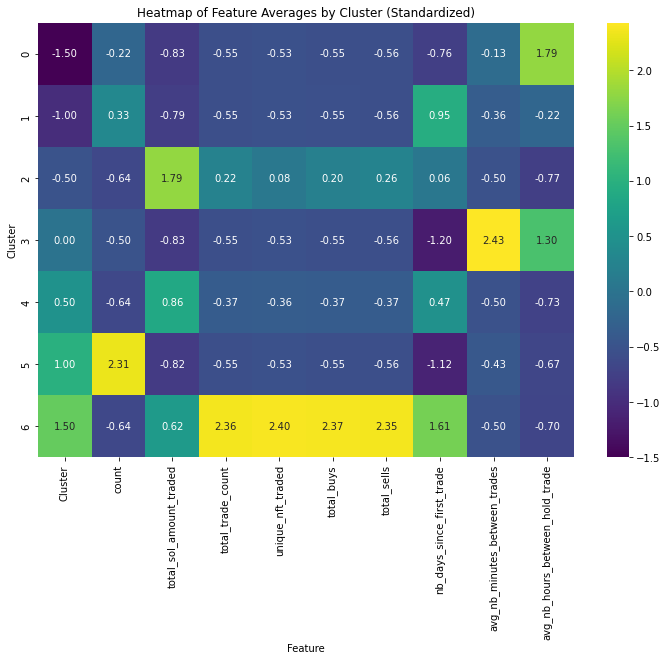

In [11]:
scaler = StandardScaler()
scaled_cluster_means = scaler.fit_transform(cluster_summary)
scaled_cluster_means_df = pd.DataFrame(scaled_cluster_means, index=cluster_summary.index, columns=cluster_summary.columns)

# Visualize using heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(scaled_cluster_means_df, annot=True, cmap='viridis', fmt=".2f")
plt.title('Heatmap of Feature Averages by Cluster (Standardized)')
plt.ylabel('Cluster')
plt.xlabel('Feature')
plt.show()

In [12]:
nft_trades_clustered = nft_trades[nft_trades['Cluster']==1].reset_index(drop=True)
nft_trades_clustered.to_csv('nft_traders_classified.csv',index=False)


In [13]:

nft_trades_clustered['avg_sol_per_trade'] = nft_trades_clustered['total_sol_amount_traded']/nft_trades_clustered['total_trade_count']

nft_trades_clustered['normalized_avg_nb_hours_between_hold_trade'] = (nft_trades_clustered['avg_nb_hours_between_hold_trade'] - nft_trades_clustered['avg_nb_hours_between_hold_trade'].min()) / (nft_trades_clustered['avg_nb_hours_between_hold_trade'].max() - nft_trades_clustered['avg_nb_hours_between_hold_trade'].min())
nft_trades_clustered['normalized_avg_sol_per_trade'] = (nft_trades_clustered['avg_sol_per_trade'] - nft_trades_clustered['avg_sol_per_trade'].min()) / (nft_trades_clustered['avg_sol_per_trade'].max() - nft_trades_clustered['avg_sol_per_trade'].min())
nft_trades_clustered['normalized_unique_nft_traded'] = (nft_trades_clustered['unique_nft_traded'] - nft_trades_clustered['unique_nft_traded'].min()) / (nft_trades_clustered['unique_nft_traded'].max() - nft_trades_clustered['unique_nft_traded'].min())

In [16]:
weight_total_sol = 1/3
weight_avg_hours = 1/3
weight_unique_nft = 1/3

nft_trades_clustered['combined_score'] = (nft_trades_clustered['normalized_avg_sol_per_trade'] * weight_total_sol) + \
                               (nft_trades_clustered['normalized_avg_nb_hours_between_hold_trade'] * weight_avg_hours)+ \
                               (nft_trades_clustered['normalized_unique_nft_traded'] * weight_unique_nft)
                               
nft_trades_clustered['rank'] = nft_trades_clustered['combined_score'].rank(ascending=False)
nft_trades_clustered.sort_values('rank').reset_index(drop=True).to_csv('nft_traders_ranking.csv',index=False)
nft_trades_clustered.sort_values('rank').head(20)

,address,total_sol_amount_traded,total_trade_count,unique_nft_traded,total_buys,total_sells,nb_days_since_first_trade,avg_nb_minutes_between_trades,avg_nb_hours_between_hold_trade,Cluster,AnomalyScore,avg_sol_per_trade,normalized_avg_nb_hours_between_hold_trade,normalized_avg_sol_per_trade,normalized_unique_nft_traded,combined_score,rank
7901,Cp4DYtWgqTwst7brhz7jPhEPrJ3cQ1viUehfJ1m4hPQD,962.891106,4612,3582,1525,3087,404,231.014094,9433.201987,1,0.025701,0.208780,0.775093,0.000276,0.839428,0.538266,1.0
386,ChH4s33PiVhYwbZW2HLKgQUXLWWUR4YXnGVrXNRzRKzX,9283.583507,14,13,1,13,374,65474.357143,7110.338462,1,0.241502,663.113108,0.642194,0.885882,0.002813,0.510296,2.0
32012,DHZSdSTzsn5u8SJZY7JgurBEmRs2o75gBevYuRJbNThi,112.979116,3865,3764,3695,170,419,156.213972,5690.592843,1,0.065678,0.029231,0.560965,0.000036,0.882091,0.481031,3.0
16147,FQk2pQjkzThiovNHXfEtj4qMp63AB6Sz4yFnmrEfCJzj,398.605513,1910,1909,1842,68,382,411.915707,12644.925245,1,0.064296,0.208694,0.958847,0.000276,0.447257,0.468793,4.0
53307,APpLMogkqgDBQF9vStptofH4tJNY2cYBnbzxrGiTQeSz,19.322606,2417,2409,65,2352,420,250.651221,10497.531165,1,0.059099,0.007994,0.835987,0.000008,0.564463,0.466819,5.0
34762,EymEdd8NmyNorVFhrKwqJgy6uj2iD2L1HeuG2TAiZDbG,92.417868,4542,2985,2984,1558,405,128.402026,5819.127589,1,0.040108,0.020347,0.568319,0.000024,0.699484,0.422609,6.0
56,FwHQiQ5m2nCFtmxWCYGh4GzfzFdzcvYXuwKkcJXBxrqr,23204.542897,31,28,27,4,291,13609.419355,146.733333,1,0.263759,748.533642,0.243781,1.000000,0.006329,0.416703,7.0
50687,66hxzxxsgWFts8yrzfhDHCbJTQPsdQUNHjv8veHTWw2n,24.861412,4313,4267,4261,52,8,2.542546,3.710577,1,0.095318,0.005764,0.235598,0.000005,1.000000,0.411868,8.0
47349,2WtZPexHzuSineMWbibn9dfCNwd1NRFApBZoZjiN3XRf,33.865281,4156,4147,4136,20,353,65.632339,399.045833,1,0.075807,0.008149,0.258217,0.000008,0.971871,0.410032,9.0
21840,DJBHGNxosDcJb16u7Lgy83f9k5Seru1KMbzK16EX9qVR,246.181845,974,974,960,14,392,1145.520534,13364.210714,1,0.086217,0.252753,1.000000,0.000335,0.228083,0.409472,10.0
